In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import networkx as nx
import itertools
import pandas as pd
import numpy as np
from stellargraph import StellarGraph
from rdkit.Chem import AllChem, DataStructs
import json
from sklearn import preprocessing, feature_extraction, model_selection
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow import keras
import tensorflow as tf

import stellargraph as sg
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import HinSAGELinkGenerator
from stellargraph.layer import HinSAGE, link_classification
from tensorflow.keras import Model, optimizers, losses, metrics

import multiprocessing
from stellargraph import datasets
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from tensorflow.keras import mixed_precision

In [4]:
g = nx.read_graphml("./graph/train_graph.gml")
species_features_dummy = pd.read_csv("./data/species_features.csv.gz", index_col=0)
#species_features_dummy = pd.read_csv("./data/species_BaseNEncoder.csv.gz", index_col=0)
#species_features_dummy = pd.read_csv("./data/species_Multi_dim_scale.csv.gz", index_col=0)
molecule_features_dummy = pd.read_csv("./data/molecule_features.csv.gz", index_col=0).astype("int8")
df_agg = pd.read_csv("./data/lotus_agg_train.csv.gz", index_col=0)
#molecule_features_dummy = pd.read_csv("./data/molecule_features_dummy.csv.gz", index_col=0).astype('int8')

In [5]:
species_test = species_features_dummy[~species_features_dummy.index.isin(df_agg.organism_name)].index
mol_test = molecule_features_dummy[~molecule_features_dummy.index.isin(df_agg.structure_smiles_2D)].index

In [6]:
species_feat = species_features_dummy[species_features_dummy.index.isin(df_agg.organism_name)]
molecule_feat = molecule_features_dummy[molecule_features_dummy.index.isin(df_agg.structure_smiles_2D)]

In [7]:
G = StellarGraph.from_networkx(g,
                               node_features={'species': species_feat,
                                              'molecule': molecule_feat})
print(G.info())
G.check_graph_for_ml()

StellarDiGraph: Directed multigraph
 Nodes: 149920, Edges: 613300

 Node types:
  molecule: [115623]
    Features: float32 vector, length 27
    Edge types: molecule-present_in->species
  species: [34297]
    Features: float32 vector, length 80
    Edge types: species-has->molecule

 Edge types:
    species-has->molecule: [306650]
        Weights: all 1 (default)
        Features: none
    molecule-present_in->species: [306650]
        Weights: all 1 (default)
        Features: none


In [6]:
batch_size = 128 #default: 200
epochs = 30 #default: 20
num_samples = [3, 1]
num_workers = multiprocessing.cpu_count()-2

In [7]:
# Define an edge splitter on the original graph G:
edge_splitter_test = EdgeSplitter(G)

# Randomly sample a fraction p=0.3 of all positive links, and same number of negative links, from G, and obtain the
# reduced graph G_test with the sampled links removed:
G_test, edge_ids_test, edge_labels_test = edge_splitter_test.train_test_split(
    p=0.1, method="global", keep_connected=False, edge_label="present_in"
)

Network has 306650 edges of type present_in
Network has 306650 edges of type present_in
** Sampled 30665 positive and 30665 negative edges. **


In [8]:
# Define an edge splitter on the reduced graph G_test:
edge_splitter_train = EdgeSplitter(G_test)

# Randomly sample a fraction p=0.3 of all positive links, and same number of negative links, from G_test, and obtain the
# reduced graph G_train with the sampled links removed:
G_train, edge_ids_train, edge_labels_train = edge_splitter_train.train_test_split(
    p=0.1, method="global", keep_connected=False, edge_label="present_in"
)

Network has 275985 edges of type present_in
Network has 275985 edges of type present_in
** Sampled 27598 positive and 27598 negative edges. **


In [9]:
print(G_train.info())

StellarDiGraph: Directed multigraph
 Nodes: 149920, Edges: 555037

 Node types:
  molecule: [115623]
    Features: float32 vector, length 27
    Edge types: molecule-present_in->species
  species: [34297]
    Features: float32 vector, length 80
    Edge types: species-has->molecule

 Edge types:
    species-has->molecule: [306650]
        Weights: all 1 (default)
        Features: none
    molecule-present_in->species: [248387]
        Weights: all 1 (default)
        Features: none


In [10]:
print(G_test.info())

StellarDiGraph: Directed multigraph
 Nodes: 149920, Edges: 582635

 Node types:
  molecule: [115623]
    Features: float32 vector, length 27
    Edge types: molecule-present_in->species
  species: [34297]
    Features: float32 vector, length 80
    Edge types: species-has->molecule

 Edge types:
    species-has->molecule: [306650]
        Weights: all 1 (default)
        Features: none
    molecule-present_in->species: [275985]
        Weights: all 1 (default)
        Features: none


In [11]:
train_gen = HinSAGELinkGenerator(G_train,
                                 batch_size=batch_size,
                                 num_samples=num_samples,
                                 head_node_types=["molecule", "species"],
                                seed=42)
train_flow = train_gen.flow(edge_ids_train, edge_labels_train, shuffle=True, seed=42)

In [12]:
test_gen = HinSAGELinkGenerator(G_test,
                                batch_size=batch_size,
                                num_samples=num_samples,
                                head_node_types=["molecule", "species"],
                               seed=42)
test_flow = test_gen.flow(edge_ids_test, edge_labels_test, seed=42)

In [13]:
hinsage_layer_sizes = [1024, 1024]
hinsage = HinSAGE(layer_sizes=hinsage_layer_sizes,
                  generator=train_gen,
                  bias=True,
                  dropout=0.3,
                 activations=['elu','selu'])

In [14]:
# Build the model and expose input and output sockets of graphsage model
# for link prediction
x_inp, x_out = hinsage.in_out_tensors()

/usr/local/Caskroom/mambaforge/base/envs/stellar_graph/lib/python3.10/site-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [15]:
prediction = link_classification(output_dim=1,
                                 output_act="sigmoid",
                                 edge_embedding_method="l1")(x_out)

link_classification: using 'l1' method to combine node embeddings into edge embeddings


In [16]:
model = keras.Model(inputs=x_inp, outputs=prediction)

initial_learning_rate = 0.1
final_learning_rate = 0.001
learning_rate_decay_factor = (final_learning_rate / initial_learning_rate)**(1/epochs)
steps_per_epoch = int(edge_ids_train.shape[0]/batch_size)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate=initial_learning_rate,
                decay_steps=steps_per_epoch,
                decay_rate=learning_rate_decay_factor,
                staircase=True)

optimizer=keras.optimizers.Adam(learning_rate=lr_schedule)
#optimizer = mixed_precision.LossScaleOptimizer(optimizer)

model.compile(
    optimizer=optimizer,
    loss=keras.losses.binary_crossentropy,
    metrics=["AUC"],
)

In [17]:
init_train_metrics = model.evaluate(train_flow, workers=num_workers, verbose=2)
init_test_metrics = model.evaluate(test_flow, workers=num_workers, verbose=2)

print("\nTrain Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

2023-07-10 08:51:30.321831: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


432/432 - 8s - loss: 0.6958 - auc: 0.4456 - 8s/epoch - 19ms/step


2023-07-10 08:51:39.272871: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


480/480 - 7s - loss: 0.6959 - auc: 0.4379 - 7s/epoch - 15ms/step

Train Set Metrics of the initial (untrained) model:
	loss: 0.6958
	auc: 0.4456

Test Set Metrics of the initial (untrained) model:
	loss: 0.6959
	auc: 0.4379


In [18]:
callbacks = keras.callbacks.EarlyStopping(monitor="val_loss",
                                          patience=5,
                                          mode="auto",
                                          restore_best_weights=True)

history = model.fit(train_flow,
                    epochs=epochs,
                    workers=num_workers,
                    validation_data=test_flow,
                    verbose=2,
                    callbacks=[callbacks],
                    validation_split=0.0,
                    shuffle=True
                   )

Epoch 1/30


2023-07-10 08:51:46.757199: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-07-10 08:52:09.407389: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


432/432 - 32s - loss: 0.5973 - auc: 0.7332 - val_loss: 0.4905 - val_auc: 0.8487 - 32s/epoch - 74ms/step
Epoch 2/30
432/432 - 29s - loss: 0.4617 - auc: 0.8594 - val_loss: 0.3581 - val_auc: 0.9267 - 29s/epoch - 68ms/step
Epoch 3/30
432/432 - 34s - loss: 0.3953 - auc: 0.9008 - val_loss: 0.3192 - val_auc: 0.9397 - 34s/epoch - 78ms/step
Epoch 4/30
432/432 - 29s - loss: 0.3648 - auc: 0.9165 - val_loss: 0.2873 - val_auc: 0.9486 - 29s/epoch - 67ms/step
Epoch 5/30
432/432 - 29s - loss: 0.3427 - auc: 0.9268 - val_loss: 0.2844 - val_auc: 0.9526 - 29s/epoch - 67ms/step
Epoch 6/30
432/432 - 29s - loss: 0.3273 - auc: 0.9335 - val_loss: 0.2627 - val_auc: 0.9576 - 29s/epoch - 67ms/step
Epoch 7/30
432/432 - 24s - loss: 0.3134 - auc: 0.9393 - val_loss: 0.2551 - val_auc: 0.9607 - 24s/epoch - 56ms/step
Epoch 8/30
432/432 - 26s - loss: 0.3017 - auc: 0.9436 - val_loss: 0.2506 - val_auc: 0.9616 - 26s/epoch - 61ms/step
Epoch 9/30
432/432 - 24s - loss: 0.2918 - auc: 0.9474 - val_loss: 0.2433 - val_auc: 0.9647 

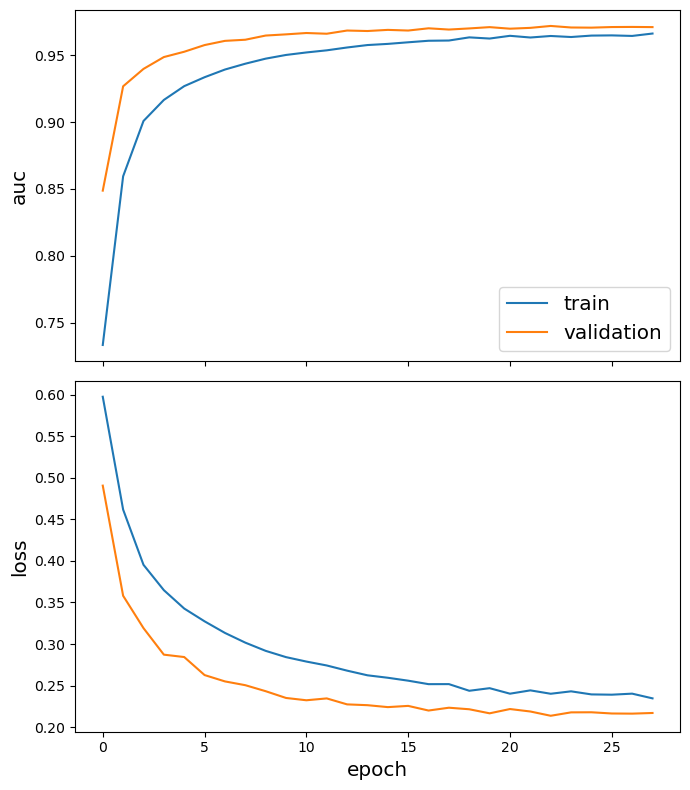

In [19]:
sg.utils.plot_history(history)

In [20]:
train_metrics = model.evaluate(train_flow, verbose=2)
test_metrics = model.evaluate(test_flow, verbose=2)

print("\nTrain Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

2023-07-10 09:05:03.124920: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


432/432 - 7s - loss: 0.1842 - auc: 0.9790 - 7s/epoch - 16ms/step


2023-07-10 09:05:10.133782: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


480/480 - 7s - loss: 0.2210 - auc: 0.9701 - 7s/epoch - 15ms/step

Train Set Metrics of the trained model:
	loss: 0.1842
	auc: 0.9790

Test Set Metrics of the trained model:
	loss: 0.2210
	auc: 0.9701


In [21]:
def predict(model, flow, iterations=10):
    predictions = []
    for _ in range(iterations):
        predictions.append(model.predict(flow, workers=-1).flatten())

    return np.mean(predictions, axis=0)

In [22]:
test_pred = HinSAGELinkGenerator(G,
                                 batch_size=batch_size,
                                num_samples=num_samples,
                                head_node_types=["molecule", "species"],
                                seed=42).flow(edge_ids_test, edge_labels_test, seed=42)

In [23]:
predictions = predict(model, test_pred)

2023-07-10 09:05:38.019934: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


  8/480 [..............................] - ETA: 7s

2023-07-10 09:05:46.648576: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


  8/480 [..............................] - ETA: 7s

2023-07-10 09:05:54.675224: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


  8/480 [..............................] - ETA: 7s

2023-07-10 09:06:02.367864: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


  8/480 [..............................] - ETA: 7s

2023-07-10 09:06:09.861277: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


  7/480 [..............................] - ETA: 8s

2023-07-10 09:06:18.076211: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


  8/480 [..............................] - ETA: 8s

2023-07-10 09:06:25.718771: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


  7/480 [..............................] - ETA: 8s

2023-07-10 09:06:33.394555: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


  7/480 [..............................] - ETA: 8s

2023-07-10 09:06:43.369722: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


  7/480 [..............................] - ETA: 9s

2023-07-10 09:06:51.552191: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


480/480 [==============================] - 8s 16ms/step


In [24]:
middle = int(len(predictions)/2)

In [25]:
np.mean(predictions[:middle])

0.90282243

In [26]:
np.mean(predictions[middle:])

0.09097105

In [27]:
test = predictions[(predictions>0.5) | (predictions<0.5)]
test = test>0.5

In [28]:
test = test.astype('int8')

(array([24267.,  2052.,  1198.,   933.,   957.,  1056.,  1420.,  2707.,
         5609., 21131.]),
 array([2.09109459e-07, 9.99939218e-02, 1.99987635e-01, 2.99981356e-01,
        3.99975061e-01, 4.99968797e-01, 5.99962473e-01, 6.99956238e-01,
        7.99949944e-01, 8.99943650e-01, 9.99937356e-01]),
 <BarContainer object of 10 artists>)

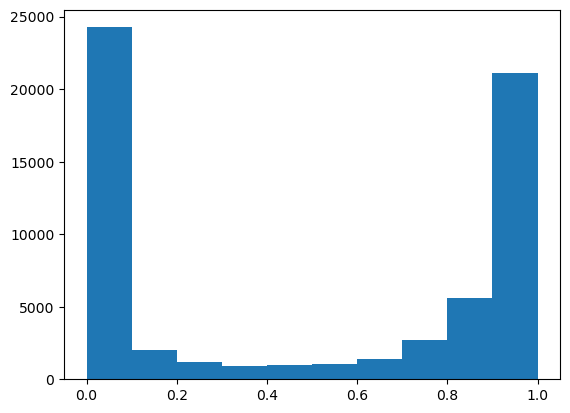

In [29]:
plt.hist(predictions)

In [30]:
np.where((predictions>0.9) | (predictions<0.1))

(array([    1,     2,     4, ..., 61327, 61328, 61329]),)

In [31]:
sum(test == edge_labels_test[np.where((predictions>0.5) | (predictions<0.5))])/len(test)

0.9588781999021686

In [32]:
len(test)/len(predictions)

1.0

In [33]:
model.save(f"./model/batch_{batch_size}_layer_{hinsage_layer_sizes[0]}_m_to_s")

2023-07-10 09:06:59.910157: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'input_6' with dtype float and shape [?,3,80]
	 [[{{node input_6}}]]
2023-07-10 09:06:59.920982: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'input_5' with dtype float and shape [?,3,27]
	 [[{{node input_5}}]]
2023-07-10 09:06:59.930122: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'input_3' with dtype float and shape [?,3,80]
	 [[{{node input_3}}]]
2023-07

2023-07-10 09:07:00.887930: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,3,27]
	 [[{{node inputs}}]]
2023-07-10 09:07:00.895421: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,3,80]
	 [[{{node inputs}}]]
2023-07-10 09:07:00.906324: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,3,1,27]
	 [[{{node inputs}}]]
2023-07-10 

2023-07-10 09:07:01.094725: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'x' with dtype float and shape [?,1,1024]
	 [[{{node x}}]]
2023-07-10 09:07:01.094822: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'x_1' with dtype float and shape [?,1,3,1024]
	 [[{{node x_1}}]]
2023-07-10 09:07:01.103273: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'x' with dtype float and shape [?,1,1024]
	 [[{{node x}}]]
2023-07-10 09:07:01.103345: I t

2023-07-10 09:07:02.087320: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,3,80]
	 [[{{node inputs}}]]
2023-07-10 09:07:02.106524: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,3,27]
	 [[{{node inputs}}]]
2023-07-10 09:07:02.132205: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,3,80]
	 [[{{node inputs}}]]
2023-07-10 09

2023-07-10 09:07:02.775313: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,3,1024]
	 [[{{node inputs}}]]
2023-07-10 09:07:02.792764: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,3,1024]
	 [[{{node inputs}}]]
2023-07-10 09:07:02.809135: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1,1024]
	 [[{{node inputs}}]]
2023-07

INFO:tensorflow:Assets written to: ./model/batch_128_layer_1024_m_to_s/assets


INFO:tensorflow:Assets written to: ./model/batch_128_layer_1024_m_to_s/assets
